In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
from matplotlib.patheffects import Normal, Stroke
import seaborn as sns
from adjustText import adjust_text

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


sns.set_style('darkgrid')
pd.set_option('display.float_format', '{:.3f}'.format)
plt.rcParams['figure.figsize'] = [13, 7]


In [2]:
db_config = {'user': 'postgres',
             'pwd': '****',
             'host': 'localhost',
             'port': 5432,
             'db': 'db_mentor_copy_2'}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                         db_config['pwd'],
                                                         db_config['host'],
                                                         db_config['port'],
                                                         db_config['db'])
engine = create_engine(connection_string)


#### Контекст кейса и задача <br>
Вы работаете аналитиком в онлайн-сервисе “Поиск ментора”.<br>
Это сервис, который помогает менторам и менти найти друг друга.<br>
Встречи проходят на площадке сервиса. Назначить встречу можно в личном кабинете после авторизации на сайте.<br>
Продакт-менеджер начал подготовку к новому этапу развития приложения и попросил вас собрать данные о работе сервиса.

## Исходные таблицы из БД

In [3]:
users = pd.read_sql_query(
    'select * from users',
    con=engine
)
users


,user_id,reg_date,role,region_id
0,20012,2021-01-01,mentee,5
1,20001,2021-01-01,mentee,2
2,20002,2021-01-01,mentee,1
3,20003,2021-01-01,mentee,2
4,20005,2021-01-01,mentee,1
...,...,...,...,...
3114,10168,2022-09-11,mentee,4
3115,10170,2022-09-12,mentee,2
3116,10039,2022-09-13,mentee,3
3117,10153,2022-09-14,mentee,1


In [4]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3119 entries, 0 to 3118
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    3119 non-null   int64         
 1   reg_date   3119 non-null   datetime64[ns]
 2   role       3119 non-null   object        
 3   region_id  3119 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 97.6+ KB


In [5]:
# Проверяем на совпадение id менторов и менти
mentees = users[users['role'] == 'mentee']['user_id']
mentors = users[users['role'] == 'mentor']['user_id']

check_lst = list(set(mentees) & set(mentors))

print('Есть пересечения менти и менторов?\n',
      len(check_lst) != 0)


Есть пересечения менти и менторов?
 False


Один и тот же пользователь не может быть менти и ментором.

In [6]:
# проверяем id менти и менторов на уникальность
print(
    users[['user_id']].count()[0], users[['user_id']].nunique()[0], sep=', '
)


3119, 3119


Все id в таблице с пользователями уникальны.

In [7]:
region = pd.read_sql_query(
    'select * from region',
    con=engine
)
region


,id,name
0,0,Другое
1,1,г Москва
2,2,г Санкт-Петербург
3,3,Ростовская обл
4,4,Краснодарский край
5,5,Ленинградская обл
6,6,Московская обл
7,7,Нижегородская обл
8,8,Новосибирская обл
9,9,Омская обл


In [8]:
region['name'].nunique(), region['name'].count()


(20, 20)

In [9]:
region.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20 non-null     int64 
 1   name    20 non-null     object
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes


In [10]:
sessions = pd.read_sql_query(
    'select * from sessions',
    con=engine
)
sessions


,session_id,session_date_time,mentor_id,mentee_id,session_status,mentor_domain_id
0,1,2021-02-12,30009,20136,canceled,3
1,2,2021-02-12,30032,20003,finished,6
2,3,2021-02-12,30020,20026,finished,2
3,4,2021-02-12,30025,20006,finished,6
4,5,2021-02-12,30011,20006,finished,5
...,...,...,...,...,...,...
10416,10417,2022-09-15,30369,21770,finished,6
10417,10418,2022-09-15,30384,21802,finished,3
10418,10419,2022-09-15,30318,21837,finished,4
10419,10420,2022-09-15,30424,21842,finished,5


In [11]:
sessions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10421 entries, 0 to 10420
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_id         10421 non-null  int64         
 1   session_date_time  10421 non-null  datetime64[ns]
 2   mentor_id          10421 non-null  int64         
 3   mentee_id          10421 non-null  int64         
 4   session_status     10421 non-null  object        
 5   mentor_domain_id   10421 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 488.6+ KB


In [12]:
# проверяем id сессий на уникальность
print(
    sessions[['session_id']].count()[0], sessions[['session_id']].nunique()[0], sep=', '
)


10421, 10421


ID Сессий уникальны.

id менторов и менти в таблице sessions корректны?

In [13]:
# проверяем пересечение id из столбцов
check_lst = list(set(sessions['mentee_id']) & set(sessions['mentor_id']))
print('Есть пересечения из стобцов менти и менторов?\n',
      len(check_lst) != 0)

# проверяем роли для менти и менторов дял таблицы sessions
print('Есть менти, которые не имеют роли mentee?\n',
      sessions['mentee_id'][~sessions['mentee_id'].isin(mentees)].any()
      )
print('Есть менторы, которые не имеют роли mentor?\n',
      sessions['mentor_id'][~sessions['mentor_id'].isin(mentors)].any()
      )


Есть пересечения из стобцов менти и менторов?
 False
Есть менти, которые не имеют роли mentee?
 False
Есть менторы, которые не имеют роли mentor?
 False


In [14]:
domain = pd.read_sql_query(
    'select * from domain',
    con=engine
)
domain


,id,name
0,1,Продуктовая аналитика
1,2,AB тестирование
2,3,Визуализация данных
3,4,DS
4,5,Python для аналитики данных
5,6,Машинное обучение
6,7,SQL


In [15]:
domain.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7 non-null      int64 
 1   name    7 non-null      object
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes


#### Задание 1

Изучите данные и подготовьте ответы на вопросы продакт-менеджера.

1. Какое количество менторов и менти взаимодействуют каждый месяц на нашей платформе?<br> Как меняется этот показатель из месяца в месяц?

In [16]:
sql1 = '''
with cnt_unique as (
	select		date_trunc('month', session_date_time)::date as "month",
				count(distinct mentor_id) as mentor_cnt,
				count(distinct mentee_id) as mentee_cnt,
				max(session_date_time)::date as last_day
	from 		sessions as s
	group by 	"month"
	order by 	"month"
),
cnt_lag as (
	select	*,
			lag(mentor_cnt) over (order by month) as mentor_lag,
			lag(mentee_cnt) over (order by month) as mentee_lag
	from 	cnt_unique
)
select	"month",
		mentor_cnt,
		round((mentor_cnt - mentor_lag)/mentor_lag::numeric*100, 2) as mentor_chng,
		mentee_cnt,
		round((mentee_cnt - mentee_lag)/mentee_lag::numeric*100, 2) as mentee_chng,
		last_day
from	cnt_lag
'''

df = pd.read_sql_query(sql1, con=engine)


In [17]:
df


,month,mentor_cnt,mentor_chng,mentee_cnt,mentee_chng,last_day
0,2021-02-01,22,NaN,34,NaN,2021-02-28
1,2021-03-01,36,63.640,48,41.180,2021-03-31
2,2021-04-01,48,33.330,54,12.500,2021-04-30
3,2021-05-01,70,45.830,91,68.520,2021-05-31
4,2021-06-01,78,11.430,92,1.100,2021-06-30
5,2021-07-01,86,10.260,104,13.040,2021-07-31
6,2021-08-01,117,36.050,153,47.120,2021-08-31
7,2021-09-01,135,15.380,179,16.990,2021-09-30
8,2021-10-01,157,16.300,212,18.440,2021-10-31
9,2021-11-01,195,24.200,256,20.750,2021-11-30


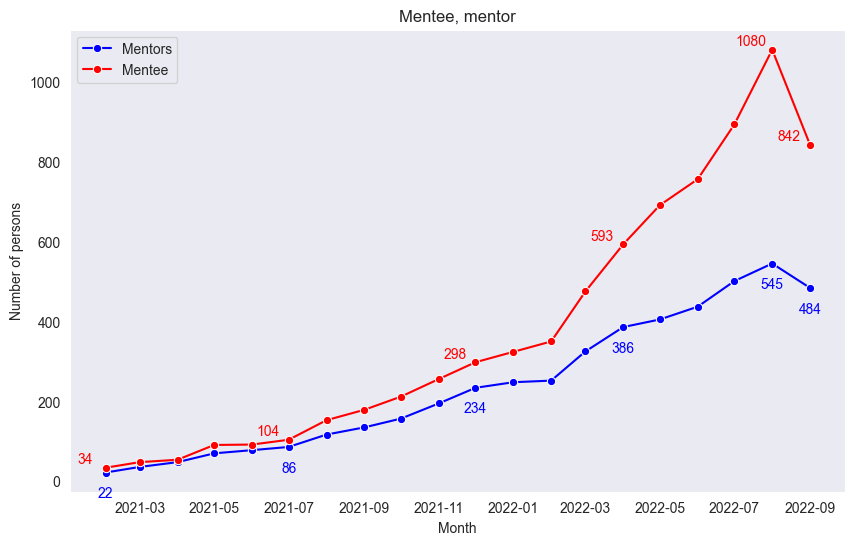

In [18]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=df['month'], y=df['mentor_cnt'], color='b', label='Mentors', markers=True, marker='o')
sns.lineplot(x=df['month'], y=df['mentee_cnt'], color='r', label='Mentee', markers=True, marker='o')
plt.ylim(min(df['mentee_cnt'])-60, max(df['mentee_cnt'])+50)

columns = ['mentor_cnt', 'mentee_cnt']
colors = ['b', 'r']
x_position = [0, -15]
y_position = [-18, 3]

for col, c, x_p, y_p in zip(columns, colors, x_position, y_position):
    for x, y in zip(df['month'], df[col]):
        # list with quantiles for data
        lst = [0, 0.25, 0.5, 0.75, 1]
        describe_nearest = []
        [describe_nearest.append(df[col].quantile(el, interpolation='nearest')) for el in lst]
        describe_nearest.append(df[col].values[-1::][0])
        # add annotation if value in quantiles list
        if y in describe_nearest:
            label = '{:.0f}'.format(y)
            plt.annotate(
                label,
                (x, y),
                textcoords='offset points',
                xytext=(x_p, y_p),
                ha='center',
                color=c
            )
ax.legend()
ax.grid(False)

plt.xlabel('Month')
plt.ylabel('Number of persons')
plt.title('Mentee, mentor')
plt.show()


За последний неполный месяц количество менторов и менти составило 484 и 842 соответственно, за последний полный месяц 545 и 1080 соответственно.<br>
На протяжении наблюдаемого периода наблюдается положительная динамика количества менторов и менти.<br>
Учитывая, что за последний неполный месяц (до 2022-09-15) динамика количества менторов и менти составила -11.2% и -22% соответственно, можно предположить, что по итогам сентября их количество превысит показатели за август.

2. Сколько у нас менторов и менти, которые еще не приняли участие ни в одной встрече?

In [19]:
sql2 = '''
	select		u.role,
				count(distinct u.user_id) as user_cnt
	from		users as u
	left join 	sessions as s
	on			u.user_id = s.mentee_id
	where		role = 'mentee' and
				s.session_id is null
	group by 	u.role
union all
	select		u.role,
				count(distinct u.user_id) as user_cnt
	from 		users as u
	left join 	sessions as s
	on 			u.user_id = s.mentor_id
	where		role = 'mentor' and
				s.session_id is null
	group by 	1
'''
df2 = pd.read_sql_query(sql2, con=engine)


Менторы и менти без записей о сессиях.

In [20]:
df2


,role,user_cnt
0,mentee,662


In [21]:
sql2_2 = '''
with sfin as (
		select		distinct u.user_id
		from		users as u
		left join	sessions as s
		on 			u.user_id = s.mentee_id
		where		role = 'mentee' and
					session_status = 'finished'
)
select		count(distinct u2.user_id)
from		users as u2
left join	sessions as s2
			on u2.user_id = s2.mentee_id
where		role = 'mentee' and
			s2.session_status = 'canceled' and
			u2.user_id not in
				(select user_id from sfin as sf)
'''
df2_2 = pd.read_sql_query(sql2_2, con=engine)


Менти только с отмененными сессиями.

In [22]:
df2_2


,count
0,24


Все менторы принимали участие в сессиях. <br>
Количество менти, не участвовавших в сессиях составило 662 человека. Также 24 менти имеют только отмененные сессии.<br>

Также можно изучить помесячно количество менти без сессий и их долю.

In [23]:
sql2_3 = '''
select		date_trunc('month', u.reg_date)::date as reg_month,
			sum(count(distinct u.user_id)	filter(where s.session_id is null))		over(order by date_trunc('month', u.reg_date)::date) as no_ses_users,
			sum(count(distinct u.user_id)	filter(where s.session_id is not null))	over(order by date_trunc('month', u.reg_date)::date) as ses_users,
			round(
				sum(count(distinct u.user_id)	filter(where s.session_id is null))		over(order by date_trunc('month', u.reg_date)::date)::numeric/
				sum(count(distinct u.user_id))	over(order by date_trunc('month', u.reg_date)::date)*100, 2) as no_ses_users_ptc
from 		users as u
left join 	sessions as s
on 			u.user_id = s.mentee_id
left join 	region as r
on 			u.region_id = r.id
where 		u.role = 'mentee'
group by	reg_month
order by	reg_month
'''

df2_3 = pd.read_sql_query(sql2_3, con=engine)


In [24]:
df2_3


,reg_month,no_ses_users,ses_users,no_ses_users_ptc
0,2021-01-01,29.000,145.000,16.670
1,2021-02-01,48.000,247.000,16.270
2,2021-03-01,86.000,365.000,19.070
3,2021-04-01,111.000,461.000,19.410
4,2021-05-01,141.000,567.000,19.920
5,2021-06-01,177.000,672.000,20.850
6,2021-07-01,224.000,765.000,22.650
7,2021-08-01,257.000,846.000,23.300
8,2021-09-01,289.000,939.000,23.530
9,2021-10-01,319.000,1042.000,23.440


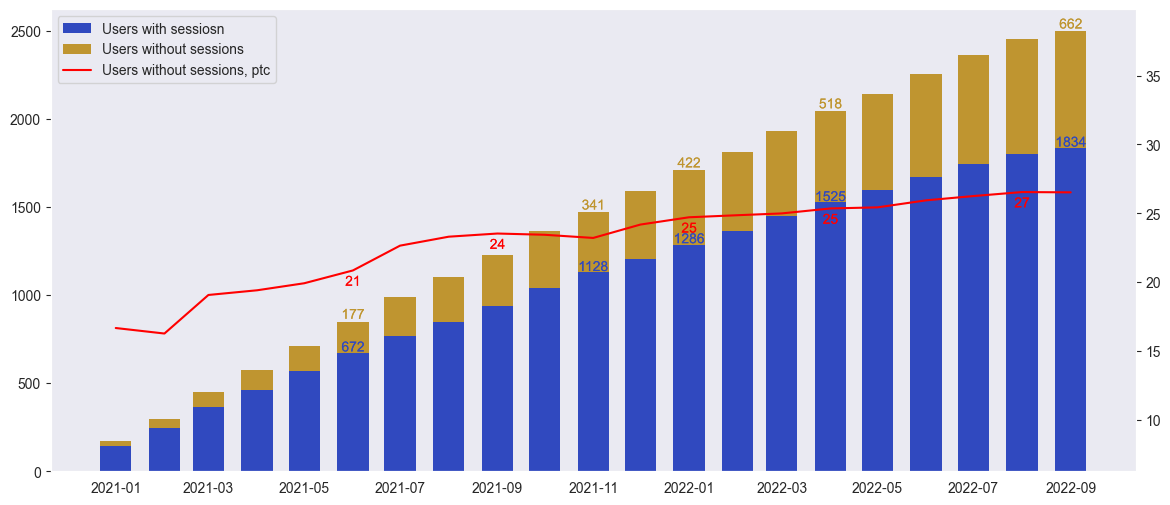

In [25]:
# преобразование массива
df2_3_g = (
    df2_3.astype({'reg_month': 'datetime64[ns]'})
    .set_index('reg_month')
)

# вычисление квантилей
quantiles = df2_3_g.quantile([0.25, 0.5, 0.6, 0.75, 1], numeric_only=True, interpolation='nearest')

# оставляем только квантили
to_label = df2_3_g.apply(lambda s: s.isin(quantiles[s.name]))
labels = df2_3_g.where(to_label)

# задаем оси
fig, bar_ax = plt.subplots(figsize=(14, 6))
line_ax = bar_ax.twinx()

# столбцы с завершенными сессиями
finished_bars = bar_ax.bar(
    x=df2_3_g.index,
    height=df2_3_g['ses_users'],
    label='Users with sessiosn',
    linewidth=0,
    width=20,
    color='#3049BF'
)

# метки будут добавлены в словарь, чтобы использовать их как высоту
bar_labels = {}
for (month, value), rect in zip(labels['ses_users'].items(), finished_bars):
    if pd.isna(value):
        continue
    # определяем центр столбца
    center_x, _ = rect.get_center()

    bar_labels[month] = bar_ax.annotate(
        f'{value:.0f}',
        # задаем расположение меток
        (center_x, rect.get_y() + rect.get_height()),
        textcoords='offset points',
        xytext=(0, 1),
        ha='center',
        color=rect.get_facecolor(),
        path_effects=[Stroke(linewidth=0, foreground='white'), Normal()]
    )

fig.canvas.draw_idle()

canceled_bars = bar_ax.bar(
    x=df2_3_g.index,
    height=df2_3_g['no_ses_users'],
    bottom=df2_3_g['ses_users'],
    label='Users without sessions',
    linewidth=0,
    width=20,
    color='#BF9530'
)

for (month, value), rect in zip(labels['no_ses_users'].items(), canceled_bars):
    if pd.isna(value):
        continue

    center_x, _ = rect.get_center()
    existing_label = bar_labels.get(month)

    # если метка для 'ses_finished' существует, то нужно убедиться,
    # что метка для 'ses_finished' не перекрывается
    if existing_label:
        label_top = (
            bar_ax.transData.inverted()
            .transform(existing_label.get_window_extent())
            .flat[-1]
        )
    else:
        label_top = 0

    bar_y = max(rect.get_y() + rect.get_height(), label_top)
    bar_labels[month] = bar_ax.annotate(
        f'{value:.0f}',
        (center_x, bar_y),
        textcoords='offset points',
        xytext=(0, 2),
        ha='center',
        color=rect.get_facecolor(),
        path_effects=[Stroke(linewidth=0, foreground='gainsboro'), Normal()]
    )

line_ax.set_ylim(min(df2_3_g['no_ses_users_ptc'])-10, max(df2_3_g['no_ses_users_ptc'])*1.5)
line_ax.plot(
    df2_3_g.index,
    df2_3_g['no_ses_users_ptc'],
    color='r',
    label='Users without sessions, ptc'
)
for month, value in labels['no_ses_users_ptc'].dropna().items():
    line_ax.annotate(
        f'{value:.0f}',
        (month, value),
        textcoords='offset points',
        xytext=(0, -11),
        ha='center',
        color='r',
        path_effects=[Stroke(linewidth=0, foreground='white'), Normal()]
    )

bar_ax.grid(False)
line_ax.grid(False)

h1, l1 = bar_ax.get_legend_handles_labels()
h2, l2 = line_ax.get_legend_handles_labels()

handles = h1 + h2
labels_legend = l1 + l2

bar_ax.legend(handles, labels_legend)

plt.show()


На основе графика можно сделать вывод, что доля менти без сессий стабильна в 2022 году колеблется немного вырола с 24,7% до 26,5%.<br>
Непосредственно для расчета корреляции рассчитаем динамику показателей по неделям. Таким образом, выборка будет больших размеров, что повысит точность расчетов.


In [26]:
sql2_4 = '''
	select		date_trunc('week', u.reg_date)::date	as reg_week,
				count(distinct u.user_id)	filter(where s.session_id is null)		as mentee_without_ses,
				count(distinct u.user_id)	filter(where s.session_id is not null)	as mentee_with_ses,
				count(distinct u.user_id) 	as all_mentee
	from 		users as u
	left join 	sessions as s
	on 			u.user_id = s.mentee_id
	left join 	region as r
	on 			u.region_id = r.id
	where 		u.role = 'mentee'
	group by 	reg_week
	order by 	reg_week
'''
df2_4 = pd.read_sql_query(sql2_4, con=engine)


In [27]:
df2_4


,reg_week,mentee_without_ses,mentee_with_ses,all_mentee
0,2020-12-28,1,12,13
1,2021-01-04,9,34,43
2,2021-01-11,5,30,35
3,2021-01-18,6,39,45
4,2021-01-25,8,30,38
...,...,...,...,...
85,2022-08-15,7,20,27
86,2022-08-22,8,10,18
87,2022-08-29,5,13,18
88,2022-09-05,4,16,20


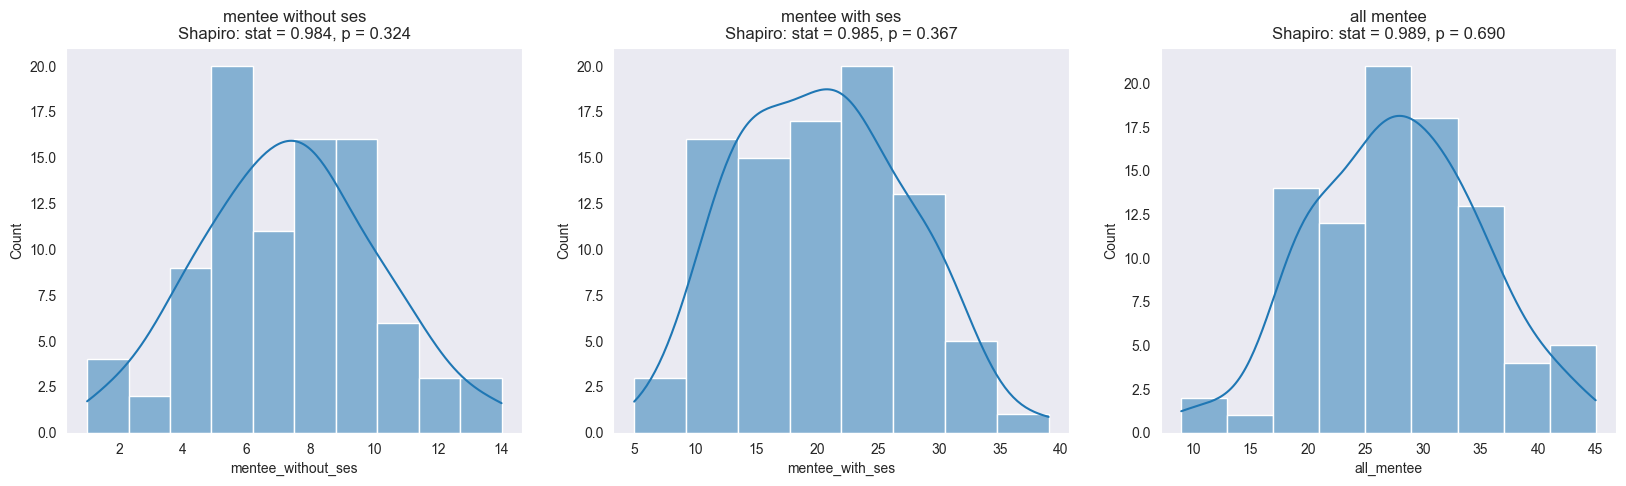

In [28]:
# проверяем данные на нормальность распределениия
columns = set(df2_4.columns[1:])
col_number = np.arange(0, len(columns))
figure, axis = plt.subplots(1, len(columns), figsize=(20, 5))

for i, col in zip(col_number, columns):
    stat, p = stats.shapiro(df2_4[col])
    ax = sns.histplot(df2_4[col], kde=True, ax=axis[i])
    col1 = col.replace('_', ' ')
    axis[i].set_title(f'{col1}\nShapiro: stat = {stat:.3f}, p = {p:.3f}')
    ax.grid(False)

plt.show()


Результаты W-теста Шапиро-Уилка позволяет сделать вывод, что все данные соответствуют нормальному распределению (P > 0.05). <br>
В связи с этим допустимо использовать коэффициент корреляции Пирсона.<br>

H0: данные соответствуют нормальному распределению.<br>
P-value > 0.05.<br>
Вероятность наблюдения нормального распределения в результате случайной ошибки выборки выше заданного уровня значимости, а значит нулевая гипотеза не отклонена.

In [29]:
columns = df2_4.columns[1:3]

Pearson = np.array([])
p_value = np.array([])
CI_left = np.array([])
CI_right = np.array([])

for col in columns:
    res = stats.pearsonr(df2_4['all_mentee'], df2_4[col])

    Pearson = np.append(Pearson, res[0])
    p_value = np.append(p_value, res[1])
    CI_left = np.append(CI_left, res.confidence_interval()[0])
    CI_right = np.append(CI_right, res.confidence_interval()[1])

all_mentee_corr = (
    pd.DataFrame(
        {
            'Pearson': Pearson,
            'p_value': p_value,
            'CI_left': CI_left,
            'CI_right': CI_right
        },
        index=columns)
    .reset_index()
    .rename(columns={'index': 'Correlation between all mentee'})
)

all_mentee_corr['Correlation between all mentee'].replace('_', ' ', regex=True, inplace=True)
all_mentee_corr


,Correlation between all mentee,Pearson,p_value,CI_left,CI_right
0,mentee without ses,0.326,0.002,0.128,0.499
1,mentee with ses,0.925,0.000,0.887,0.950


Корреляция между общим количеством менти и менти с сессиями составила 0,925, CI 0.95: 0,88 - 0,95.<br>
Корреляция между общим количеством менти и менти без сессий – 0,33, CI 0.95: 0,13 - 0,5.<br>
Полученные коэффициенты позволяют утверждать, что с ростом привлеченных пользователей будет умеренно расти количество неактивных менти.


3. Почему они не принимают участие во встречах? Какие гипотезы нам можно проверить? <br>

Проверить гипотезу, что отдельные менторы склоны отменять свои сессии затруднительно, так как нет информации о причинах отмены сессий. Сессия может быть отменена по инициативе как ментора, так и менти.<br>
По этой причине следует сосредоточится на анализе поведения менти.<br>
Поведение менти, не участвующих в сессиях, следует рассматривать вместе с остальными пользователями, это позволит обратить внимание на закономерности в поведении пользователей сервиса в целом и сделать выводы более достоверными.<br>
Рассмотрим доли менти, не участвующих в сессиях, по регионам.

In [30]:
sql3 = '''
select		r."name" as region_name,
			count(distinct u.user_id)	filter(where s.session_id is null) as no_ses_users,
			count(distinct u.user_id)	filter(where s.session_id is not null) as ses_users,
			count(distinct u.user_id)	as all_users,
			round(
				count(distinct u.user_id)	filter(where s.session_id is null)::numeric/
				count(distinct u.user_id)*100, 2)	as no_ses_users_ptc
from 		users as u
left join 	sessions as s
on 			u.user_id = s.mentee_id
left join 	region as r
on 			u.region_id = r.id
where 		u.role = 'mentee'
group by 	region_name
order by 	4 desc
'''

df3 = pd.read_sql_query(sql3, con=engine)


In [31]:
df3


,region_name,no_ses_users,ses_users,all_users,no_ses_users_ptc
0,г Москва,131,884,1015,12.910
1,г Санкт-Петербург,114,459,573,19.900
2,Ростовская обл,92,223,315,29.210
3,Краснодарский край,60,123,183,32.790
4,Ленинградская обл,52,56,108,48.150
5,Другое,93,0,93,100.000
6,Московская обл,36,37,73,49.320
7,Нижегородская обл,25,17,42,59.520
8,Новосибирская обл,18,20,38,47.370
9,Омская обл,16,8,24,66.670


В данном случае наблюдается значительная разница в долях менти, не участвующих сессиях.<br>
Однако сопоставление показателей регионов с большим разбросом количества менти некорректно.<br>
Но эти данные позволяют утверждать, что в целом наибольший интерес к сервису проявляют жители крупнейших городов страны. <br>
Это может быть связано с тем, что компания изначально ориентируется на работу в этих регионах.

Для анализа поведения менти также рассмотрим количество менти и сессий в зависимости от количества проведенных сессий.

In [32]:
sql3_2 = '''
with session_per_mentee as (
	select		coalesce(date_trunc('year', s.session_date_time), date_trunc('year', u.reg_date))::date as year_dt,
				u.user_id as mentee_id,
				count(s.session_id) as ses
	from 		users as u
	left join 	sessions as s
	on 			u.user_id = s.mentee_id
	where 		u."role" = 'mentee'
	group by 	1, 2
)
select		ses,
			year_dt,
			count(distinct mentee_id) as mentee_cnt,
			sum(ses) as ses_amount
from 		session_per_mentee
group by 	1,
			2
order by 	2 desc,
			1 desc
'''
df3_2 = pd.read_sql_query(sql3_2, con=engine)


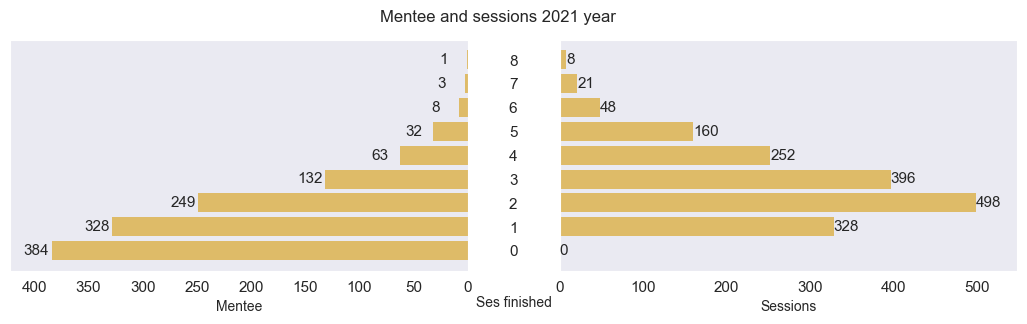

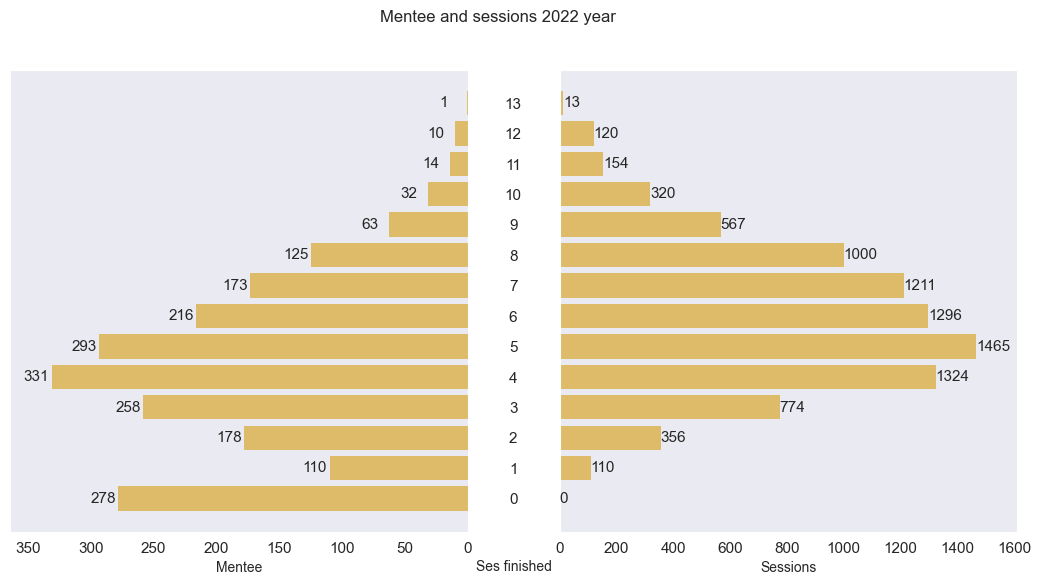

In [33]:
years = ['2021', '2022']
hight = [3, 6]
ses_finished = [-0.17, -0.09]

for y, h, s in zip(years, hight, ses_finished):
    df3_2_filter = df3_2[df3_2['year_dt'] == datetime.strptime(f'{y}-01-01', '%Y-%m-%d').date()]

    pos = np.array(df3_2_filter['ses'])
    fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=(13, h))

    left = ax_left.barh(pos, df3_2_filter['mentee_cnt'], align='center', facecolor='#DEBB68', linewidth=0)
    ax_left.bar_label(left, padding=-20, size=11, label_type='edge')
    ax_left.set_xlabel('Mentee')
    ax_left.invert_xaxis()
    ax_left.set_xlim(max(df3_2_filter['mentee_cnt'])*1.1, 0)
    ax_left.tick_params(axis='both', labelsize=11)
    ax_left.set_yticks([])
    ax_left.grid(False)
    ax_left.set_ylabel('Ses finished', rotation=0)
    ax_left.yaxis.set_label_coords(1.1, s)

    right = ax_right.barh(pos, df3_2_filter['ses_amount'], align='center', facecolor='#DEBB68', linewidth=0)
    ax_right.bar_label(right, padding=0, size=11, label_type='edge')
    ax_right.set_xlabel('Sessions')
    ax_right.set_xlim(0, max(df3_2_filter['ses_amount'])*1.1)
    ax_right.tick_params(axis='both', labelsize=11)
    ax_right.set_yticks(pos)
    ax_right.set_yticklabels(df3_2_filter['ses'], ha='center', x=-0.08)
    ax_right.grid(False)

    plt.suptitle(f'Mentee and sessions {y} year')
    plt.show()


Для анализа поведения менти в первую очередь рассмотрим количество менти и сессий в зависимости от количества проведенных сессий. <br>
Наибольшая часть проведенных сессий приходится на пользователей с 3 - 9 сессиями в 2022 году, 1 - 4 сессии - в 2021. <br>
Следует отметить, что количество сессий приходящихся на менти с количеством сессий от 1 до 5 в 2022 году  значительно растет, далее количество сессий снижается, что обусловлено тем, что доля наиболее активных менти относительно небольшая.<br>
Прежде чем делать выводы об увеличении активности менти посмотрим, сколько времени менти пользуются услугами сервиса. <br>
Имеющиеся данные также позволяют провести расчеты количества дней между регистрацией и первой сессией, первой и последней сессиями, регистрацией и последней сессией.


In [34]:
sql3_3 = '''
with ses_fin as (
-- выделяем дату регистрации, первую и последнюю сессии для менти
	select		mentee_id,
				min(u.reg_date)::date as reg_date,
				min(s.session_date_time)::date as first_ses,
				max(s.session_date_time)::date as last_ses,
				count(session_id) as ses_fin
	from 		sessions as s
	left join 	users as u
	on 			s.mentee_id = u.user_id
	group by 	mentee_id
)
-- считаем количество дней между регистрацией, первой и последней сессиями
	select		sf.mentee_id as mentee_id,
				sf.ses_fin as ses_fin,
				(sf.first_ses - sf.reg_date) as days_between_registration_and_first_sesion,
				(sf.last_ses - sf.first_ses) as days_between_first_session_and_last_session,
				(sf.last_ses - sf.reg_date) as days_between_registration_and_last_session
	from 		ses_fin as sf
	order by 	ses_fin desc
'''

df3_3 = pd.read_sql_query(sql3_3, con=engine)


In [35]:
df3_3.head(5)


,mentee_id,ses_fin,days_between_registration_and_first_sesion,days_between_first_session_and_last_session,days_between_registration_and_last_session
0,20165,16,60,512,572
1,20674,14,94,346,440
2,21014,13,67,261,328
3,21675,13,22,57,79
4,20408,13,80,400,480


Рассчитаем коэффициенты корреляции для этих данных, чтобы изучить взаимосвязи этих показателей. <br>
Менти были сгруппированы по количеству завершенных сессий.<br>
Проведем расчет коэффициентом корреляции для данных показателей.<br>
В первую очередь проверим данные подчинение закону нормального распределения.


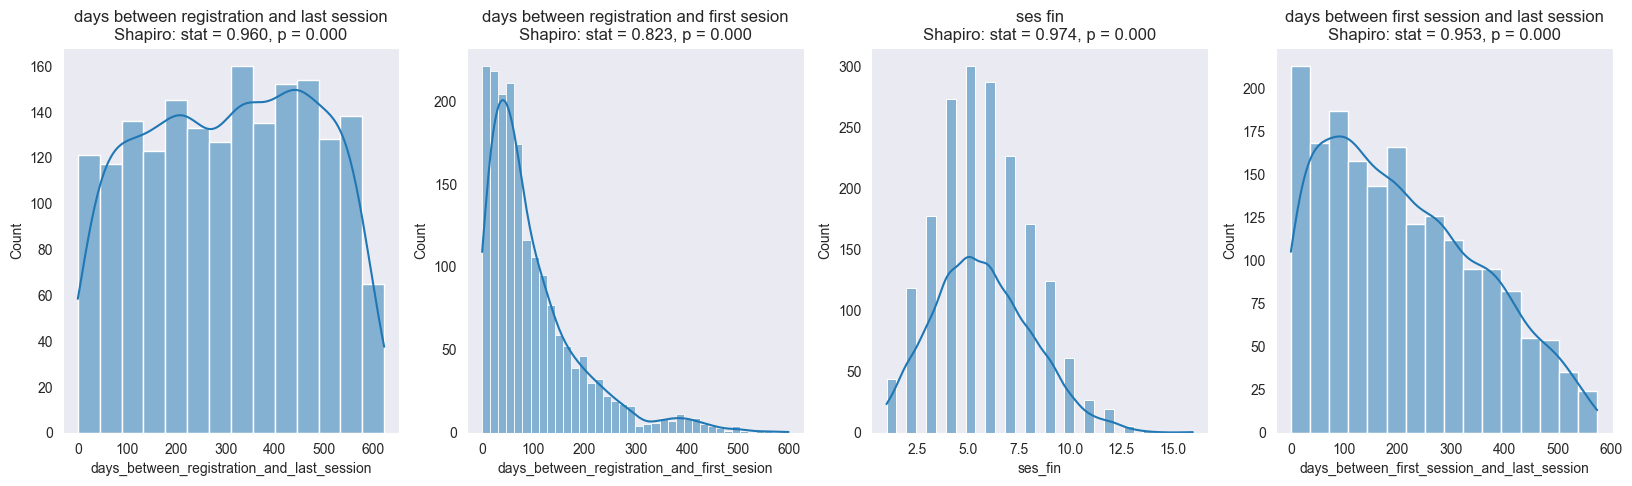

In [36]:
# проверяем данные на нормальность распределениия
columns = set(df3_3.columns[1:])
col_number = np.arange(0, len(columns))
figure, axis = plt.subplots(1, len(columns), figsize=(len(columns)*5, 5))

for i, col in zip(col_number, columns):
    stat, p = stats.shapiro(df3_3[col])
    ax = sns.histplot(df3_3[col], kde=True, ax=axis[i])
    col1 = col.replace('_', ' ')
    axis[i].set_title(f'{col1}\nShapiro: stat = {stat:.3f}, p = {p:.3f}')
    ax.grid(False)

plt.show()


Форма гистограмм  и результаты W-теста Шапиро-Уилка (p-value = 0,0) позволяет сделать вывод, что наблюдаемое распределение не соответствует нормальному.<br>
Поэтому для оценки корреляции следует рассчитывать коэффициент корреляции Спирмена. <br>

Следует обратить внимание на третью гистограмму (days between registration and first session): время между регистрацией и первой сессией.<br>
Также можно обратить внимание, что у нас больше менти, период активного использования сервиса которых относительно небольшой (первая гистограмма days between session and last session).<br>
Достаточно много пользователей записываются на первую сессию спустя некоторое время после регистрации.<br>
Более подробно разберем этот момент после расчета коэффициентов корреляции.


In [37]:
res = stats.spearmanr(df3_3['ses_fin'], df3_3[df3_3.columns[2:]])

columns = df3_3.columns[2:]
statistics = res.statistic[0][1::]
p_value = res.pvalue[0][1::]

Ses_fin_cor = pd.DataFrame({
    'Spearman': statistics,
    'p_value': p_value
},
    index=columns)

CI_left = np.array([])
CI_right = np.array([])

for corr in Ses_fin_cor['Spearman']:
    # Нижняя (ZL) и верхняя (ZU) границы преобразованного 95% доверительного интервала для коэффициента корреляции
    z_l = 0.5*np.log((1+corr)/(1-corr))-1.96*np.sqrt(1+0.5*corr**2)/np.sqrt(len(df3_3.index)-3)
    z_u = 0.5*np.log((1+corr)/(1-corr))+1.96*np.sqrt(1+0.5*corr**2)/np.sqrt(len(df3_3.index)-3)
    exp_z_l = 2.72**(2*z_l)
    exp_z_u = 2.72**(2*z_u)
    # доверительный интервал
    r_l = (exp_z_l-1)/(exp_z_l+1)
    r_r = (exp_z_u-1)/(exp_z_u+1)

    CI_left = np.append(CI_left, r_l)
    CI_right = np.append(CI_right, r_r)

CI = pd.DataFrame(
    {
        'CI_left': CI_left,
        'CI_right': CI_right
    },
    index=columns)

sessions_finished_corr = (
    Ses_fin_cor
    .merge(CI, how='outer', left_index=True, right_index=True)
    .reset_index()
    .rename(columns={'index': 'Correlation between sesssions finished'}))

sessions_finished_corr['Correlation between sesssions finished'].replace('_', ' ', regex=True, inplace=True)


In [38]:
sessions_finished_corr


,Correlation between sesssions finished,Spearman,p_value,CI_left,CI_right
0,days between registration and first sesion,-0.161,0.000,-0.206,-0.116
1,days between first session and last session,0.352,0.000,0.311,0.393
2,days between registration and last session,0.146,0.000,0.101,0.191


На основе рассчитанных коэффициентов корреляции можно сделать следующие выводы.<br>
Между количеством сессий и количеством дней между регистрацией и первой сессией наблюдается слабая отрицательная корреляция (-0.16). Из этого следует вывод, что часть наиболее активных пользователи быстрее записываются на первую сессию.<br>
Можно сделать предположение, что менти из с большим количеством сессий в целом более активны, быстрее находят подходящего ментора и чаще прибегают к услугам сервиса.

Однако значительная часть пользователей имеет достаточно длительный временной лаг между регистрацией и первой сессией. Это может происходит по разным причинам.<br>
Возможно часть пользователей регистрируется на сервисе, но не планирует сразу же использовать его. Так же менти может тратить это время на поиск подходящего ментора. Возможно стоит уделить отдельное внимание помощи пользователям с подбором преподавателя.<br>
Между количеством сессий и количеством дней между первой и последней сессией наблюдается умеренная корреляция (0,35).<br>
Из этого следует вывод, что в целом менти с большим количеством проведенных сессий дольше пользуются сервисом.<br>
Слабая корреляция (0,14) между поличеством  сессий и количеством дней между регистрациеи последней сессией в данном случае не несет какой-либо ценной информации.<br>
На основе вышесказанного можно  сделать вывод, что у компании есть пользователи, которые регулярно используют услугами сервиса. Из этого следует, что для сервиса важно уделить отдельное внимание удержанию клиентов (retention rate).<br>
Доля менти, не участвующих в сессиях, сохраняется относительно стабильной. Но учитывая, что у пользователей может пройти значительно время между регистрацией и первой сессией, часть из этих пользователей все еще может проявить активность.<br>
Однако у сервиса есть менти, которые скорее всего не будут его использовать.<br>
Поэтому для большего понимания причин отсутствия заинтересованности в участии в сессиях у пользователей следует изучить дополнительную информацию об этих менти: маркетинговые каналы, через которые пользователь узнал о сервисе, результаты опросов или другую, доступную информацию.

4. Сколько у каждого ментора в среднем успешных сессий в неделю по месяцам?<br>

In [39]:
sql4 = '''
with ses_per_week as (
-- подсчет количества сессий менторов в неделю
	select		mentor_id,
				date_trunc('month', session_date_time)::date as month_dt,
				date_trunc('week', session_date_time)::date as week_dt,
				count(session_id) as sessions
	from 		sessions as s
	where 		session_status='finished'
	group by 	1,
				2,
				3
)
-- расчет среднего количества сессий в неделю по месяцам
select	round(avg(sessions), 2) as avg_ses
from	ses_per_week
'''

df4 = pd.read_sql_query(sql4, con=engine)


In [40]:
df4


,avg_ses
0,1.220


In [41]:
sql4_1 = '''
with ses_per_week as (
-- подсчет количества сессий менторов в неделю
	select		mentor_id,
				date_trunc('month', session_date_time)::date as month_dt,
				date_trunc('week', session_date_time)::date as week_dt,
				count(session_id) as sessions
	from		sessions as s
	where		session_status='finished'
	group by 	mentor_id,
				week_dt,
				month_dt
)
-- расчет среднего количества сессий в неделю по месяцам
		select		mentor_id,
					month_dt,
					avg(sessions) as avg_ses,
					avg(sessions)::int as avg_ses_int
		from 		ses_per_week
		group by	mentor_id,
					month_dt
		order by 	3 desc
'''

df4_1 = pd.read_sql_query(sql4_1, con=engine)


In [42]:
df4_1_grouped = (
    df4_1
    .groupby(['month_dt', 'avg_ses_int'], as_index=False)
    .agg(mentor_cnt=('mentor_id', 'nunique'))
)
df4_1_grouped['date'] = pd.to_datetime(df4_1_grouped['month_dt'], format='%Y.%m.%d')


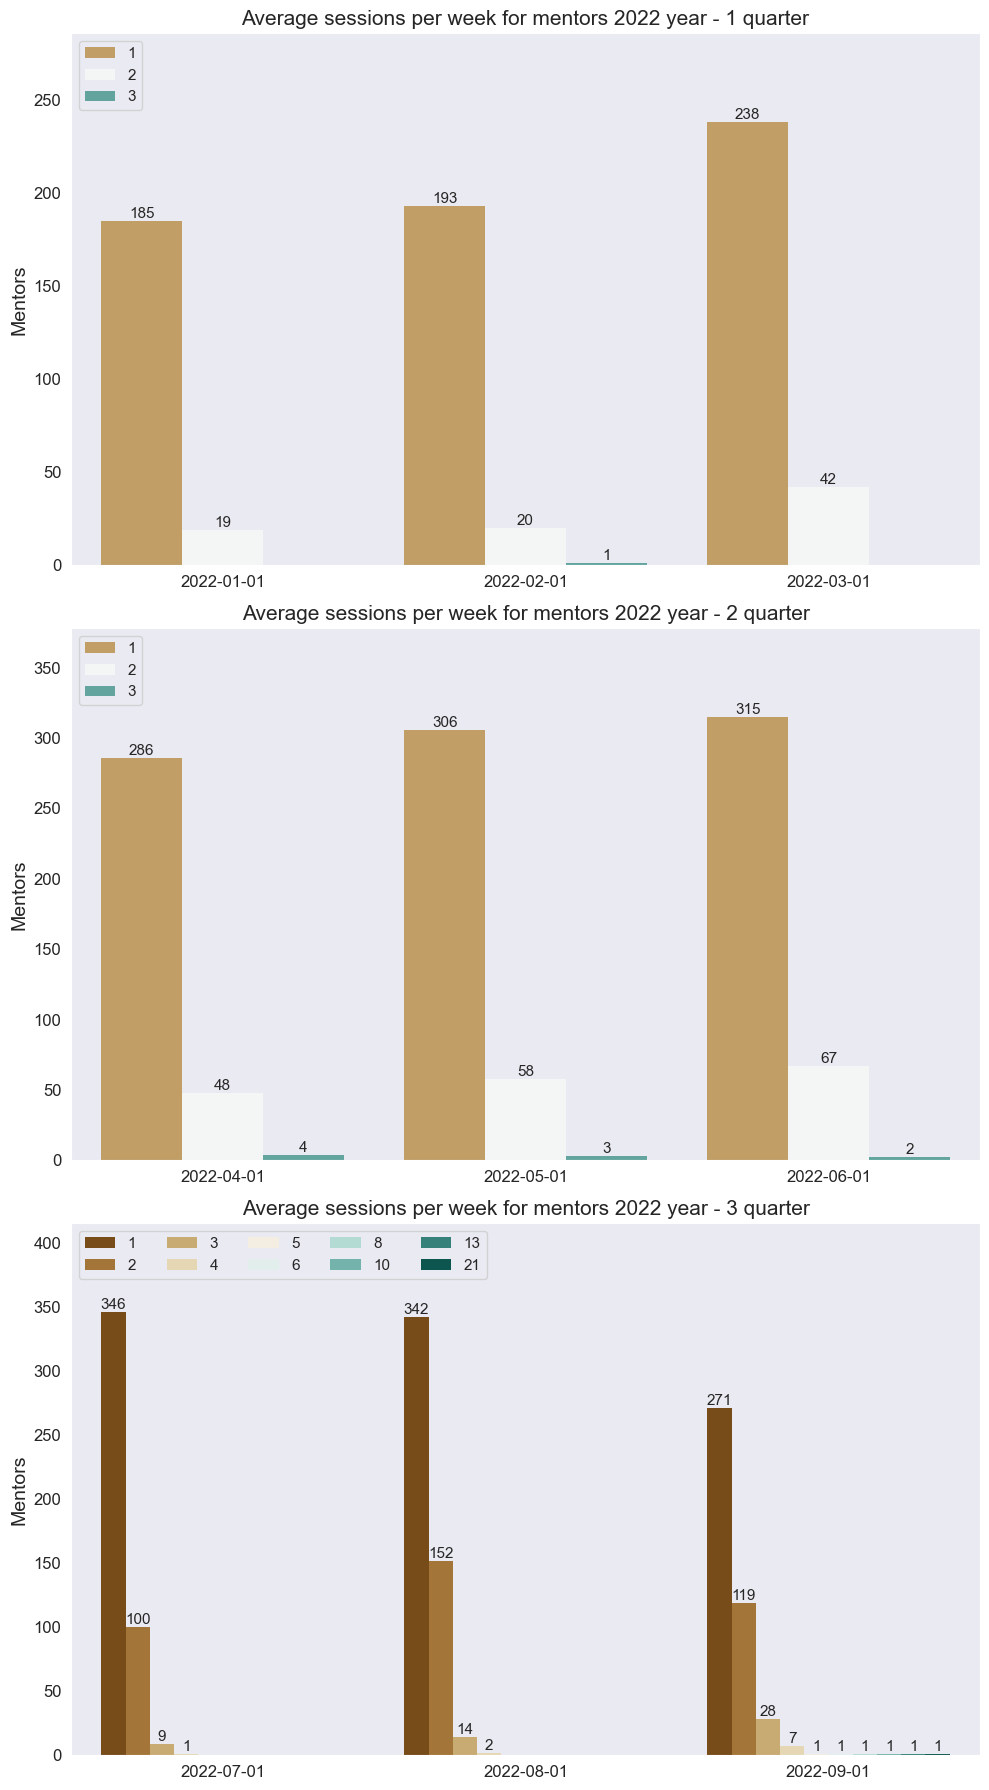

In [43]:
year = 2022
quarter = [1, 2, 3, 4]

# функция для проверки датафрейма


def is_df_empty(df):
    return len(df) != 0


# фильтр df по году
df_year = df4_1_grouped[(df4_1_grouped['date'].dt.year == year)]
# определяем количество кварталов в df
number_of_plots = len(df_year['date'].dt.quarter.unique())
# subplots
figure, axs = plt.subplots(number_of_plots, 1, figsize=(10, 6*number_of_plots))
axes = axs.ravel()

# цикл для перебора кварталов
for q, ax in zip(quarter, axes):
    # фильтр df по кварталу
    df_filtered = df_year[
        df_year['date'].dt.quarter.isin(list([q]))
    ]

    # проверка df.empty
    if is_df_empty(df_filtered):
        # график
        ax = sns.barplot(
            data=df_filtered,
            x='month_dt',
            y='mentor_cnt',
            hue='avg_ses_int',
            ax=ax,
            palette="BrBG",
            linewidth=0
        )

        for container in ax.containers:
            ax.bar_label(container, size=11)

        ax.grid(False)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Mentors', fontsize=14)
        ax.set_ylim(0, max(df_filtered['mentor_cnt'])*1.2)
        ax.legend(loc='upper left', ncols=df_filtered['avg_ses_int'].nunique()/2, fontsize=11)
        ax.set_title(f'Average sessions per week for mentors {year} year - {q} quarter', fontsize=15)

    else:
        continue
plt.tight_layout()
plt.show()


В первую очередь следует отметить, что большая часть менторов проводит в среднем 1 сессию в неделю.<br>
Однако в 2022 году часть менторов проявляет большую активность и проводит более 1 сессии в неделю, а в последние три месяца часть менторов провела более 2 сессий.<br>
Данные за август 2022 года отдельно рассматривать не будет, так как этот месяц неполный.<br>
Таким образом, можно утверждать, что активность менторов на платформе постепенно растет.


5. Определите ТОП менторов с самым большим количеством сессий за последний полный месяц. Есть ли между ними что-то общее?<br>

В первую очередь проверим, есть менторы, проводящие по нескольким направлениям?

In [44]:
sql5_check = '''
select		mentor_id,
			count(distinct d."name") as domain_cnt
from		sessions as se
left join	"domain" as d
on 			se.mentor_domain_id = d.id
group by 	mentor_id
having		count(distinct d."name")>1
'''
df5_check = pd.read_sql_query(sql5_check, con=engine)


In [45]:
df5_check


,mentor_id,domain_cnt
0,30001,6
1,30002,2
2,30003,4
3,30004,5
4,30005,7
...,...,...
618,30619,3
619,30620,7
620,30621,6
621,30622,5


In [46]:
sql5 = '''
with last_day as (
-- определяем последний день месяца
	select	    max(session_date_time::date) as dt,
                (date_trunc('month', session_date_time::date) + interval '1 month' - interval '1 day')::date as last_day
	from		sessions as s
	group by	date_trunc('month', session_date_time::date)
),
start_last_month as (
-- определяем начало последнего месяца
	select	    max(date_trunc('month', dt)::date) as start_last_month
	from		last_day as ld
),
t_full_month as (
-- определяем полные месяцы
	select	*,
			case
			when dt = last_day then 'Full month'
			when dt < (select * from start_last_month)
				then 'Full month'
			else 'Not full month'
			end full_month
	from	last_day as ld
),
last_full_month as (
-- определяем последний полный месяц
	select	date_trunc('month', max(dt))::date as month
	from	t_full_month as fm
	where	fm.full_month = 'Full month'
),
rnk_table as (
-- определяем топ менторов за последний полный месяц
	select	    s.mentor_id,
                count(s.session_id),
                (date_trunc('month', min(s.session_date_time)) + interval '1 month' - interval '1 day')::date  as month,
                dense_rank() over(order by count(s.session_id) desc) as rnk,
                min(r.name) as region
	from		sessions as s
	left join	users as u
	on		    u.user_id = s.mentor_id
	left join	region as r
	on 		    u.region_id = r.id
	left join   domain as d
	on		    s.mentor_domain_id = d.id
	where	    date_trunc('month', session_date_time)::date
			    in (select * from last_full_month)
	group by	mentor_id
	order by	rnk
)
select	*
from		rnk_table
where	rnk <= 3
'''

df5 = pd.read_sql_query(sql5, con=engine)


In [47]:
df5


,mentor_id,count,month,rnk,region
0,30597,14,2022-08-31,1,Ростовская обл
1,30595,12,2022-08-31,2,Другое
2,30586,12,2022-08-31,2,Краснодарский край
3,30550,11,2022-08-31,3,г Москва
4,30367,11,2022-08-31,3,Ленинградская обл
5,30558,11,2022-08-31,3,Новосибирская обл
6,30594,11,2022-08-31,3,Другое


В данном случае видно, что самые активные менторы преимущественно не из крупных городов.<br>
Учитывая, что значительная часть менти сосредоточена в крупнейший городах страны, можно предположить, что менторы из регионов сотрудничают с сервисом из-за потенциально более высокого заработка.<br>
Однако проверить эту гипотезу невозможно из-за отсутствия данных.

### Задание 2.

Определите точки роста.<br>

Следует обратить внимание на пользователей, которые участвовали в только нескольких сессиях или не участвовали вовсе: <br>
1) Для них следует проанализировать каналы привлечения. Если по отдельным объявлениям или маркетинговым каналам в сервис приходят неактивные менти, то следует отказаться от этих каналов привлечения пользователей.<br>
2) Также следует рассмотреть различные подходы к удержанию пользователей и повышения их лояльности, например, делать e-mail рассылки с актуальными новостями по интересующим их направлениям менторства, предложениями записаться на сессию к наиболее опытным менторам. Также для удержания и привлечения менти можно организовывать бесплатные вебинары с участием менторов.
3) Кроме того, следует убедиться, что менти не испытывают проблем с поиском подходящего ментора. И при необходимости оказывать помощь пользователям в данном направлении.

### Задание 3

Спрогнозируйте, сколько новых менторов нужно найти, если в следующие 2 недели количество активных менти увеличится на 250 человек. <br>
Объясните результат и ваше решение.

In [48]:
sql_for_pred = '''
with period_number_desc as (
	select	session_date_time::date,
			mentor_id,
			mentee_id,
			div(((max(session_date_time::date) over()) - session_date_time::date), 14) as period_number
	from sessions as s
	order by 1
)
select	min(session_date_time) as date,
		count(distinct mentor_id) as mentor_cnt,
		count(distinct mentee_id) as mentee_cnt,
		round(count(distinct mentee_id)*1.0/count(distinct mentor_id), 3) as mentee_per_mentor,
		round(count(distinct mentee_id)*1.0/(lag(count(distinct mentee_id)) over(order by min(session_date_time))), 3) as mentee_dynamic
from period_number_desc
group by period_number
order by 1
                '''

df_for_pred = pd.read_sql_query(sql_for_pred, con=engine)


In [49]:
df_for_pred


,date,mentor_cnt,mentee_cnt,mentee_per_mentor,mentee_dynamic
0,2021-02-12,12,19,1.583,NaN
1,2021-02-19,16,19,1.188,1.000
2,2021-03-05,19,21,1.105,1.105
3,2021-03-19,22,26,1.182,1.238
4,2021-04-02,26,28,1.077,1.077
5,2021-04-17,21,21,1.000,0.750
6,2021-04-30,33,40,1.212,1.905
7,2021-05-14,40,46,1.150,1.150
8,2021-05-28,32,33,1.031,0.717
9,2021-06-11,40,43,1.075,1.303


Для прогноза необходимого количества менти с использованием регрессионного анализа в первую очередь следует проверить данные на нормальность распределения и график зависимости менти и менторов.


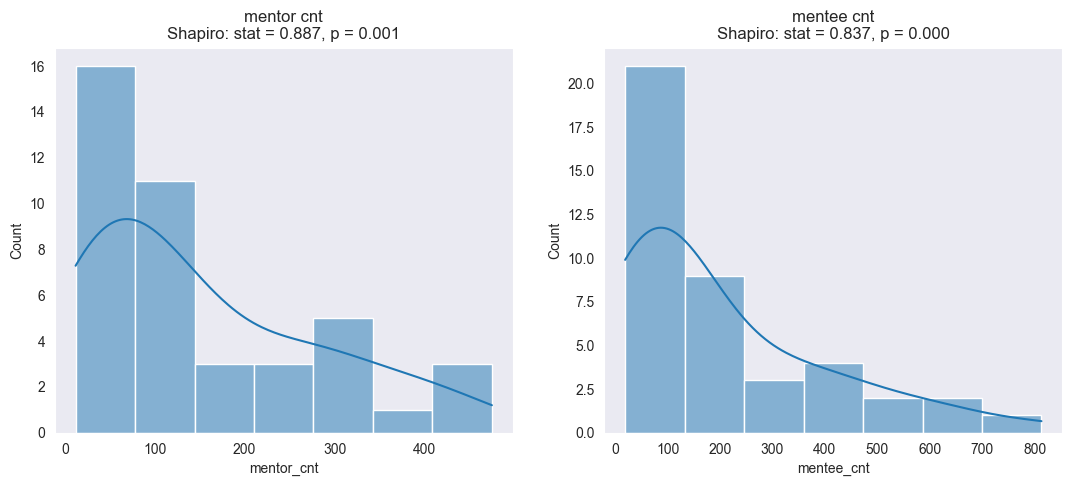

In [50]:
# проверяем данные на нормальность распределениия
columns = set(df_for_pred.columns[1:3])
col_number = np.arange(0, len(columns))
figure, axis = plt.subplots(1, len(columns), figsize=(13, 5))

for i, col in zip(col_number, columns):
    stat, p = stats.shapiro(df_for_pred[col])
    ax = sns.histplot(df_for_pred[col], kde=True, ax=axis[i])
    col1 = col.replace('_', ' ')
    axis[i].set_title(f'{col1}\nShapiro: stat = {stat:.3f}, p = {p:.3f}')
    ax.grid(False)

plt.show()


На графике видно, видно что данные не соответствует закону нормального распределения

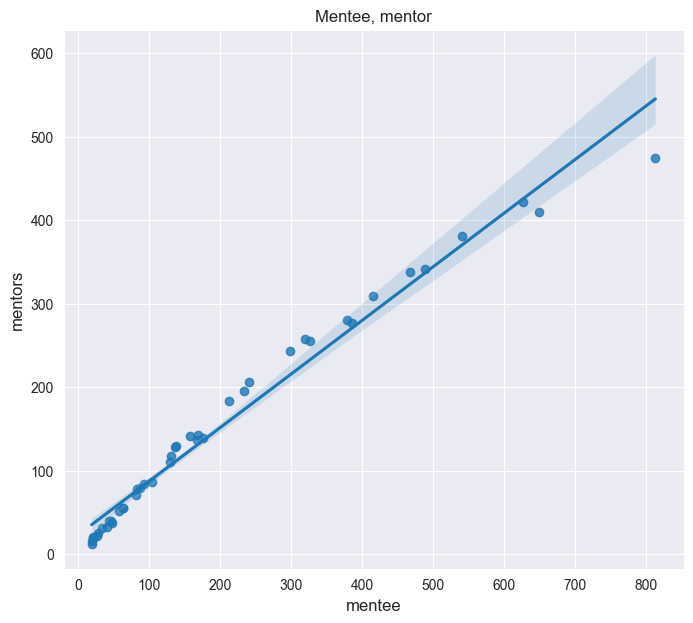

In [51]:
plt.subplots(figsize=(8, 7))
sns.regplot(data=df_for_pred, y='mentor_cnt', x='mentee_cnt')
plt.xlabel('mentee', size=12)
plt.ylabel('mentors', size=12)
plt.title('Mentee, mentor')

plt.show()


На графике видно, что для прогноза количества менторов линейная регрессия не подойдет.<br>
Также проверим данные на наличие выбросов

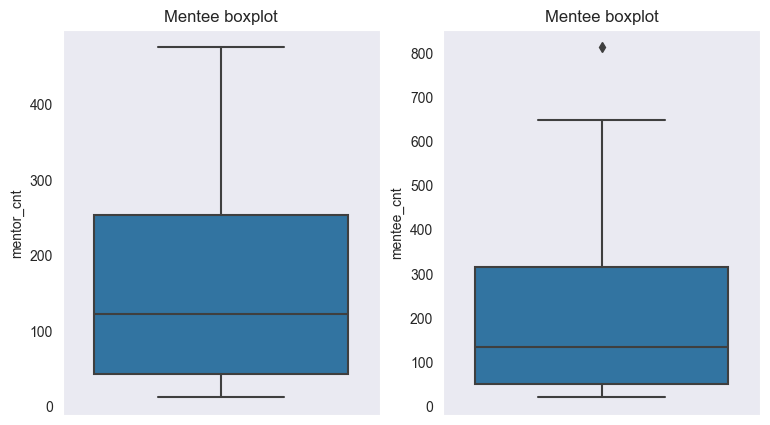

In [52]:
# проверяем данные на наличие выбросов
columns = set(df_for_pred.columns[1:3])
col_number = np.arange(0, len(columns))
figure, axis = plt.subplots(1, len(columns), figsize=(9, 5))

for i, col in zip(col_number, columns):
    sns.boxplot(data=df_for_pred, y=col, ax=axis[i])
    axis[i].set_title(f'{col}')
    axis[i].grid(False)

plt.show()


В данных есть выбросы, поэтому для оценки качества модели будет ориентироваться RMSE.

Учитывая, что линейная регрессия не подойдет для прогноза попробуем использовать полиномиальную регрессию(sklearn: PolynomialFeatures, LinearRegression, Pipeline). <br>
Переберем полиномы степеней от 2 до 5.<br>
Имеющиеся данные разделим на тренировочную и тестовую выборки в отношении 80/20.


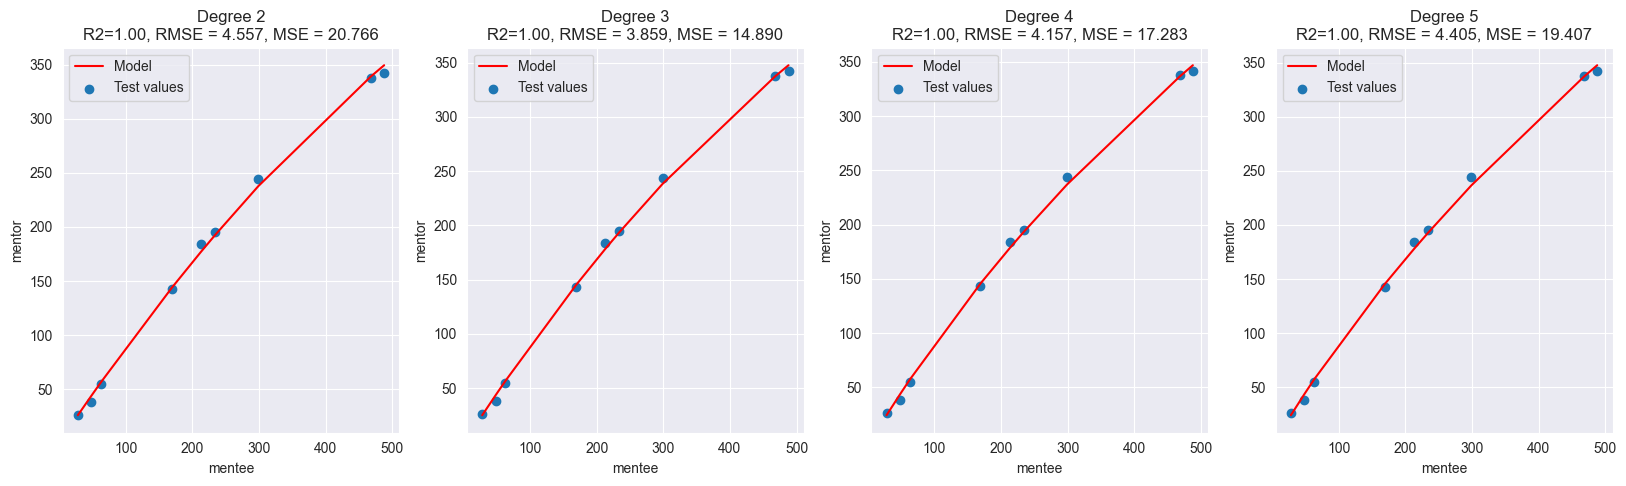

In [59]:
# полиномиальная регресия

x = df_for_pred['mentee_cnt'].to_numpy().reshape(-1, 1)
y = df_for_pred['mentor_cnt'].to_numpy()

# Разбивка на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

degrees = [2, 3, 4, 5]

plt.figure(figsize=(20, 5))
for i, degree in enumerate(degrees):
    ax = plt.subplot(1, len(degrees), i+1)

    polynomial_features = PolynomialFeatures(degree=degree)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression)
        ]
    )
    pipeline.fit(x_train, y_train)

    y_test_pred = pipeline.predict(x_test)

    # сортировка x_test и y_test_pred
    test_pred = pd.DataFrame(data={
        'x_test': x_test.reshape(1, -1)[0],
        'y_test_pred': y_test_pred
    })
    test_pred.sort_values(by='x_test', inplace=True)

    r2 = r2_score(y_test, y_test_pred)
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    mse = mean_squared_error(y_test, y_test_pred)

    plt.plot(test_pred['x_test'], test_pred['y_test_pred'], label="Model", color="r")
    plt.scatter(x_test, y_test, label="Test values")
    plt.xlabel("mentee")
    plt.ylabel("mentor")
    plt.legend(loc="best")
    plt.title(
        f"Degree {degree}\nR2={r2:.2f}, RMSE = {rmse:.3f}, MSE = {mse:.3f}"
    )

plt.show()


Из полученных моделей наиболее подходящей для прогноза выглядит первая или вторая модель (Degree 3 или Degree 4).<br>
Проверим нормальность распределения остатков и однородность дисперсии остатков для данных моделей.

In [58]:
for i, j in enumerate(degrees):
    print(i, j)


0 3
1 4


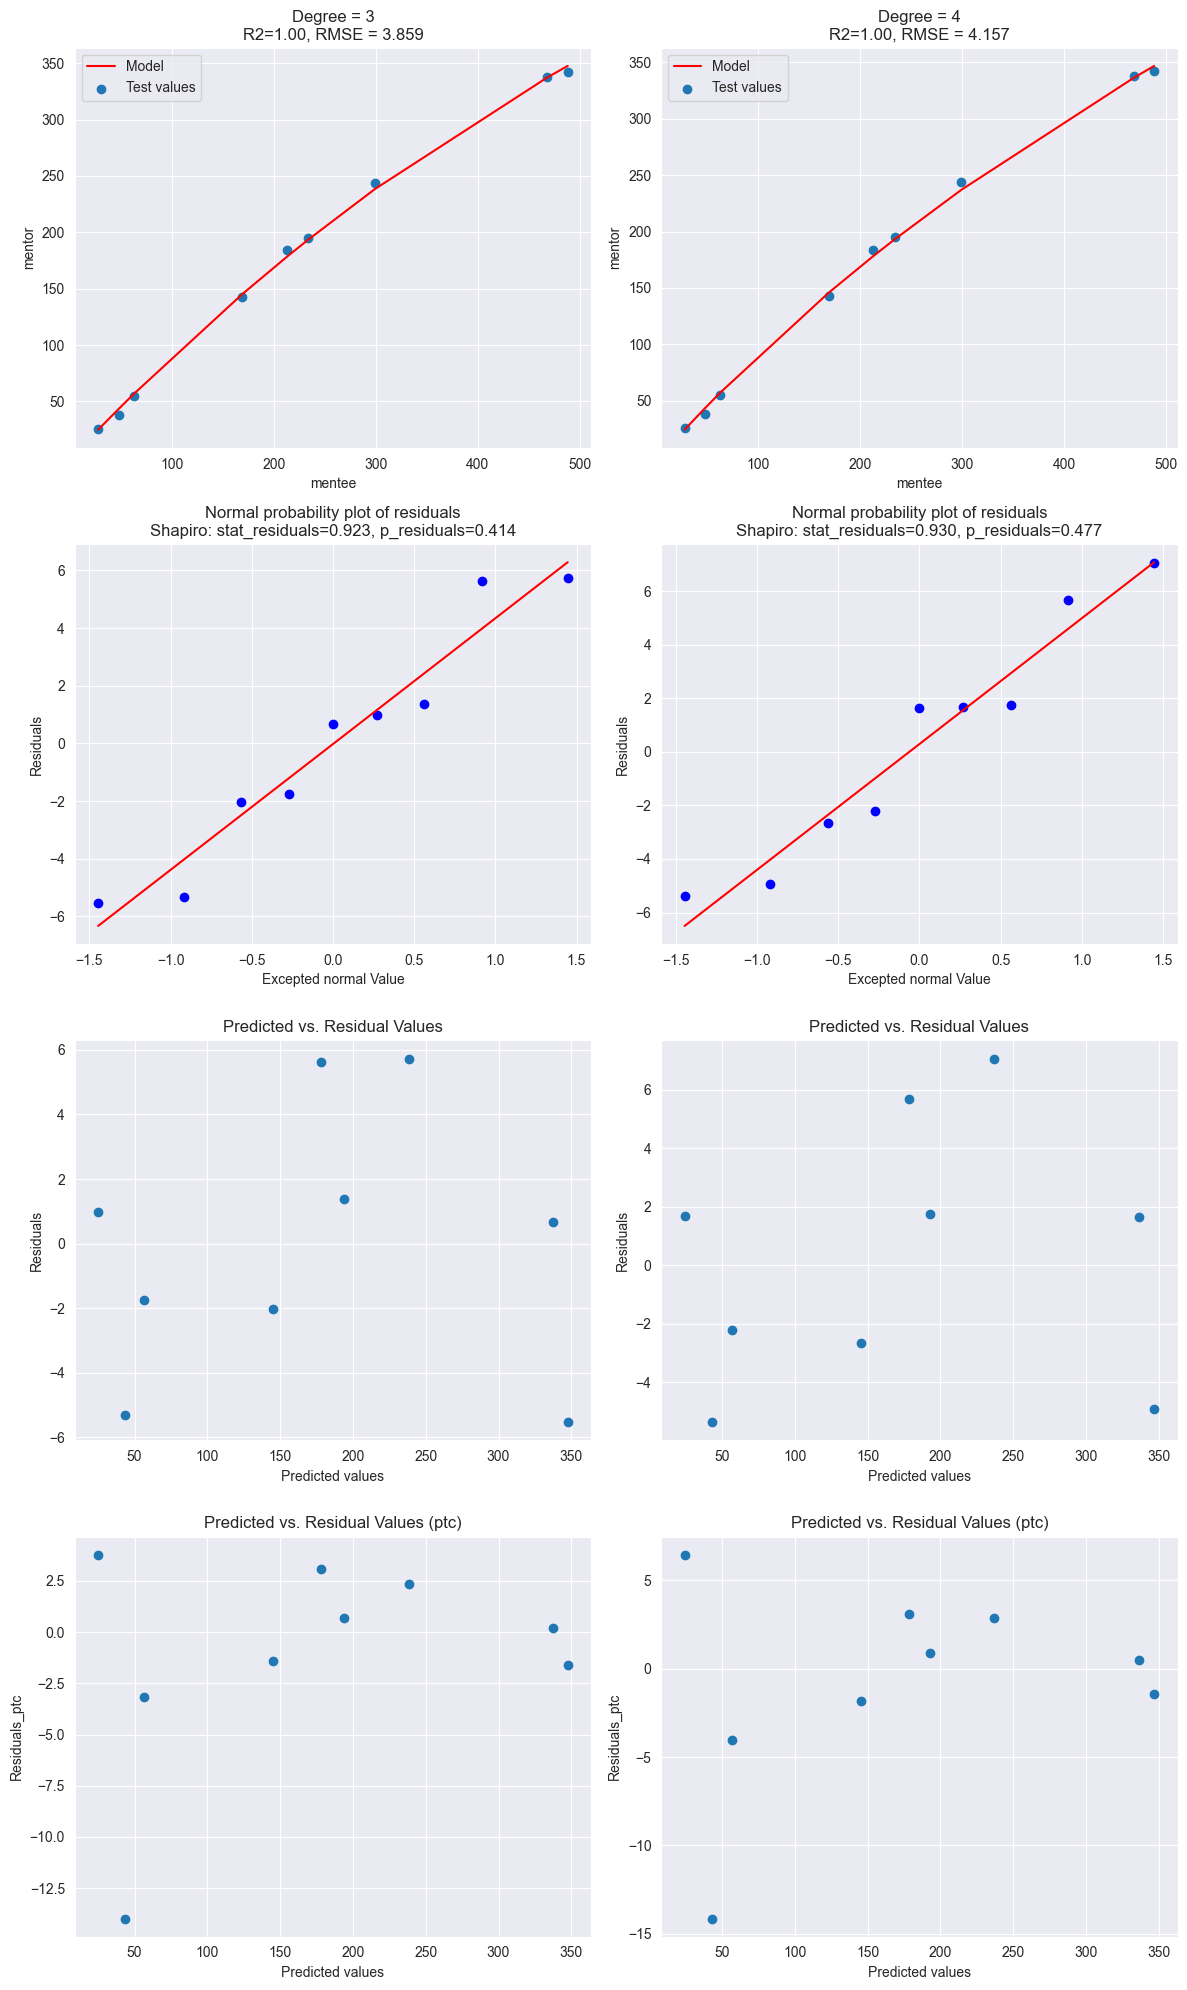

In [60]:
# определяем листы для хранения моделей и их характеристик
linear_coef = []
pipelines = []
r2_scores = []
rmse_scores = []
mse_scores = []

degrees = [3, 4]

figure, axis = plt.subplots(4, len(degrees), figsize=(6*len(degrees), 20))

for i, degree in enumerate(degrees):

    polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression)
        ]
    )
    pipeline.fit(x_train, y_train)
    pipelines.append(pipeline)

    y_test_pred = pipeline.predict(x_test)
    # сортировка x_test и y_test_pred для постоения корректного графика
    test_pred = pd.DataFrame(data={
        'x_test': x_test.reshape(1, -1)[0],
        'y_test_pred': y_test_pred
    })
    test_pred.sort_values(by='x_test', inplace=True)

    r2 = r2_score(y_test, y_test_pred)
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    mse = mean_squared_error(y_test, y_test_pred)

    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mse_scores.append(mse)
    linear_coef.append(linear_regression.coef_)

    # график для сравнения фактических значений из тестовой выборки и модели
    axis[0, i].plot(test_pred['x_test'], test_pred['y_test_pred'], label="Model", color="r")
    axis[0, i].scatter(x_test, y_test, label="Test values")
    axis[0, i].set_xlabel("mentee")
    axis[0, i].set_ylabel("mentor")
    axis[0, i].legend(loc="best")
    axis[0, i].set_title(f'Degree = {degree}\nR2={r2:.2f}, RMSE = {rmse:.3f}')
    axis[0, i].grid(True)

    residuals_non_linear = y_test - y_test_pred
    residuals_non_linear_ptc = (y_test - y_test_pred)/y_test*100

    # проверяем нормальность распределения остатков
    stat_residuals_non_linear, p_residuals_non_linear = stats.shapiro(residuals_non_linear)

    # график для проверки нормальности распределения остатков
    res = stats.probplot(residuals_non_linear, plot=axis[1, i])
    axis[1, i].set_ylabel('Residuals')
    axis[1, i].set_xlabel('Excepted normal Value')
    axis[1, i].set_title(
        f'Normal probability plot of residuals\nShapiro: stat_residuals={stat_residuals_non_linear:.3f}, p_residuals={p_residuals_non_linear:.3f}')

    # график для проверки однородности дисперсии остатков
    axis[2, i].scatter(y_test_pred, residuals_non_linear, label=None)
    axis[2, i].set_title('Predicted vs. Residual Values')
    axis[2, i].set_xlabel('Predicted values')
    axis[2, i].set_ylabel('Residuals')

    # график для проверки однородности дисперсии остатков (в процентном отношении)
    axis[3, i].scatter(y_test_pred, residuals_non_linear_ptc, label=None)
    axis[3, i].set_title('Predicted vs. Residual Values (ptc)')
    axis[3, i].set_xlabel('Predicted values')
    axis[3, i].set_ylabel('Residuals_ptc')

plt.tight_layout()
plt.show()


Рассмотрим полученные результаты.<br>
Для первой модели RMSE ниже, остатки у обоих моделей распределены нормально.<br>
Разброс отклонений для обоих моделей выглядит хаотичным, однако для первой модели отклонение от фактических значений меньше. Наибольшая ошибка наблюдается при малых значениях, в остальных случаях отклонение составляет менее 3 процентов.<br>
В таком случае для прогноза лучше использовать первую модель.

In [55]:
pipeline = pipelines[0]
degree = degrees[0]
r2 = r2_scores[0]
rmse = rmse_scores[0]
mse = mse_scores[0]


x_final_predict = np.append(x, x[-1]+250).reshape(-1, 1)
# прогноз
y_final_predict = pipeline.predict(x_final_predict)
# расчет потребности в дополнительном найме менторов
mentor_pred = round(y_final_predict[-1], 0)
mentor_last_15_days = round(y[-1], 0)
mentee_for_pred = round(x_final_predict[-1][0], 0)

# потребность в дополнительном найме менторов для периода с 2022-09-16 по 2022-10-01
need_to_hire_mentors = mentor_pred - mentor_last_15_days

# нагрузка на ментора за последние 2 недели
mentee_per_mentor_last = df_for_pred['mentee_cnt'][-1:].values[0]/df_for_pred['mentor_cnt'][-1:].values[0]

print(f'Degree - {degree}\nRMSE={rmse:.3f}, R2 = {r2:.3f}')

print(f'''Количество менти для прогноза: {mentee_for_pred:.0f}
Прогноз количества менторов: {mentor_pred:.0f}
Менторов за последние 15 дней: {mentor_last_15_days}
Потребность в найме менторов: {need_to_hire_mentors:.0f}''')
print(f'Количество менти на ментора: {round(mentee_for_pred/mentor_pred, 2):.2f}')
print(f'Количество менти на ментора за последние 30 дней: {mentee_per_mentor_last:.2f}')


Degree - 3
RMSE=3.859, R2 = 0.999
Количество менти для прогноза: 1063
Прогноз количества менторов: 538
Менторов за последние 15 дней: 475
Потребность в найме менторов: 63
Количество менти на ментора: 1.98
Количество менти на ментора за последние 30 дней: 1.71


Важно отметить, что данный прогноз подразумевает, что нагрузка на ментора увеличится. <br>
Для того, чтобы понять реалистичность данного прогноза рассмотрим динамику количества менти на ментора.

In [56]:
graph_annotates = df_for_pred[['date', 'mentee_per_mentor']].copy()
graph_annotates.at[:, 'Graph'] = ''

for i, row in graph_annotates.iterrows():
    if i == 0 or i == len(graph_annotates)-1:
        graph_annotates.at[i, 'Graph'] = 1
    elif row['mentee_per_mentor'] > graph_annotates.at[i-1, 'mentee_per_mentor'] and row['mentee_per_mentor'] > graph_annotates.at[i+1, 'mentee_per_mentor']:
        graph_annotates.at[i, 'Graph'] = 1
    elif row['mentee_per_mentor'] < graph_annotates.at[i-1, 'mentee_per_mentor'] and row['mentee_per_mentor'] < graph_annotates.at[i+1, 'mentee_per_mentor']:
        graph_annotates.at[i, 'Graph'] = 0.98

graph_annotates = (
    graph_annotates[graph_annotates['Graph'] != '']
)


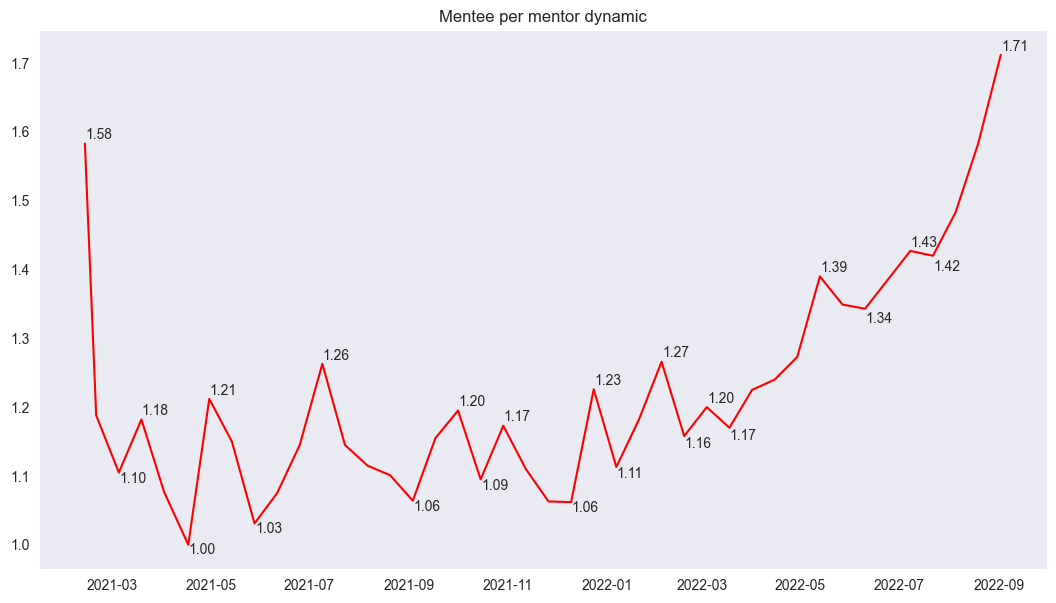

In [57]:
plt.plot(
    df_for_pred['date'],
    df_for_pred['mentee_per_mentor'],
    color="r"
)
plt.title('Mentee per mentor dynamic')
plt.grid(False)

labels = [plt.text(graph_annotates['date'][i], graph_annotates['mentee_per_mentor'][i]*graph_annotates['Graph'][i],
                   f"{graph_annotates['mentee_per_mentor'][i]:.2f}") for i in graph_annotates.index]

adjust_text(labels)

plt.show()


Динамика количества менти на ментора за 2022 год наглядно демострирует, что продуктивность менторов растет.<br>
Однако не стоит рассчитывать, что данная динамика сохранится в будущем периоде, поэтому полученный прогноз лучше рассматривать как минимальную потребность в найме менторов, так как продуктивность новых менторов неизвестна заранее.